In [37]:
# Installation (Run these cells first)
!pip install --upgrade langchain langgraph langchain-core langchain-google-genai python-dotenv requests langchain-community -q



In [ ]:
import operator
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
import requests
from google.colab import userdata

# Google Generative AI Key
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')  # Replace with your valid API Key

# Calendly API Key
CALENDLY_API_KEY = userdata.get('CALENDLY_API_KEY')  # Replace with your valid API Key
BASE_URL = "https://api.calendly.com"
headers = {"Authorization": f"Bearer {CALENDLY_API_KEY}"}

# Set up Google Generative AI
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    google_api_key=GEMINI_API_KEY,
    temperature=0.0,
)

# State structure for LangGraph
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

# Helper functions for scheduling
def get_user_uri():
    url = f"{BASE_URL}/users/me"
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json().get("resource", {}).get("uri")
    else:
        print("Failed to fetch user URI.", response.json())
        return None

def get_event_types(user_uri):
    url = f"{BASE_URL}/event_types?user={user_uri}"
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        events = response.json().get("collection", [])
        return [{"name": event['name'], "uuid": event['uri'].split('/')[-1]} for event in events]
    else:
        print("Failed to fetch event types.", response.json())
        return None

def schedule_appointment(event_uuid, invitee_name, invitee_email):
    url = f"{BASE_URL}/scheduled_events/{event_uuid}/invitees"
    payload = {"email": invitee_email, "name": invitee_name}
    response = requests.post(url, headers=headers, json=payload)
    if response.status_code == 201:
        print( "Meeting successfully scheduled.")
        return "Meeting successfully scheduled."
    else:
        print("Failed to schedule the meeting.")
        return "Failed to schedule the meeting."

# LangGraph nodes
def user_node(state: State):
    user_input = input("You: ")
    if user_input.lower() in ("bye", "quit", "stop"):
        return {"messages": [HumanMessage(content=user_input)], "__end__": True}
    return {"messages": [HumanMessage(content=user_input)]}

def llm_node(state: State):
    messages = state["messages"]
    last_message = messages[-1] if messages else None


    if isinstance(last_message, HumanMessage) and "schedule a meeting" in last_message.content.lower():
        return {"messages": messages, "__tool__": "schedule_tool"}

    # Generate LLM response
    try:
        prompt = ChatPromptTemplate.from_messages([
            ("system", "You are a helpful assistant."),
            MessagesPlaceholder(variable_name="messages"),
        ])
        chain = prompt | llm
        response = chain.invoke({"messages": messages})

        # Debugging: Log the LLM response
        print("LLM Response:", response.content)

        return {"messages": messages + [AIMessage(content=response.content)]}
    except Exception as e:
        # Handle LLM errors gracefully
        print("ERROR: LLM Node encountered an error:", str(e))
        return {"messages": messages + [AIMessage(content="I'm sorry, I couldn't process that. Please try again.")]}


def schedule_tool_node(state: State):
    user_uri = get_user_uri()
    if user_uri:
        event_data = get_event_types(user_uri)
        if event_data:
            print("\nAvailable Events:")
            for i, event in enumerate(event_data):
                print(f"{i+1}. {event['name']}")
            choice = int(input("Enter the number of the event you want to schedule: ")) - 1
            selected_event = event_data[choice]
            event_uuid = selected_event['uuid']
            invitee_name = input("Enter Your Name: ")
            invitee_email = input("Enter Your Email: ")
            result = schedule_appointment(event_uuid, invitee_name, invitee_email)

            return {"messages": state["messages"] + [AIMessage(content=result)]}
        else:
            return {"messages": state["messages"] + [AIMessage(content="No event types found. Cannot schedule a meeting.")]}

    return {"messages": state["messages"] + [AIMessage(content="Failed to retrieve user information. Cannot proceed with scheduling.")]}

def should_continue(state: State):
    messages = state["messages"]
    last_message = messages[-1] if messages else None
    if isinstance(last_message, HumanMessage) and last_message.content.lower() in ("bye", "quit", "stop"):
        return {"messages": messages + [AIMessage(content="Thanks for using this assistant! Have a great day!")], "__end__": True}
    return {"messages": messages}

# LangGraph Workflow
workflow = StateGraph(State)
workflow.add_node("user", user_node)
workflow.add_node("llm", llm_node)
workflow.add_node("schedule_tool", schedule_tool_node)
workflow.add_node("check_continue", should_continue)

workflow.add_edge(START, "user")
workflow.add_edge("user", "llm")
workflow.add_conditional_edges(
    "llm",
    lambda state: "__tool__" in state,
    {
        True: "schedule_tool",
        False: "check_continue",
    }
)
workflow.add_edge("schedule_tool", "check_continue")
workflow.add_edge("check_continue", "user")

# Compile the workflow
app = workflow.compile()

if __name__ == "__main__":
    inputs = {"messages": []}  # Initialize with an empty state
    while True:
        print("--- Starting a new turn ---")
        try:
            # Correctly invoke the workflow
            result = app.invoke(inputs)
        except Exception as e:
            print("ERROR: Workflow execution failed:", str(e))
            break

        # Check for end condition
        if "__end__" in result:
            print("Conversation ended.")
            break

        # Process and display messages
        if "messages" in result:
            new_messages = result["messages"]
            inputs["messages"] += new_messages

            for msg in new_messages:
                if isinstance(msg, HumanMessage):
                    print(f"You: {msg.content}")
                elif isinstance(msg, AIMessage):
                    print(f"LLM: {msg.content}")



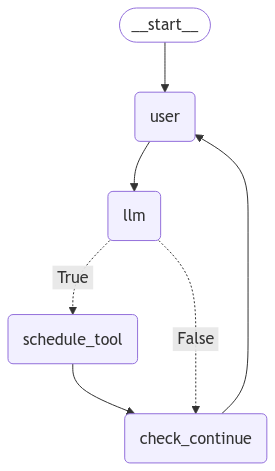

In [61]:
from IPython.display import Image, display, Markdown

display(Image(app.get_graph().draw_mermaid_png()))

In [60]:
import operator
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
import requests
from google.colab import userdata

# Google Generative AI Key
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')  # Replace with your valid API Key

# Calendly API Key
CALENDLY_API_KEY = userdata.get('CALENDLY_API_KEY')  # Replace with your valid API Key
BASE_URL = "https://api.calendly.com"
headers = {"Authorization": f"Bearer {CALENDLY_API_KEY}"}

# Set up Google Generative AI
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    google_api_key=GEMINI_API_KEY,
    temperature=0.0,
)

# State structure for LangGraph
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

# Helper functions for scheduling
def get_user_uri():
    """
    Fetch the URI of the authenticated Calendly user.

    Returns:
        str: The user's URI or None if the request fails.
    """
    url = f"{BASE_URL}/users/me"
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        user_uri = response.json().get("resource", {}).get("uri")
        print(f"User URI: {user_uri}")
        return user_uri
    else:
        print("Failed to fetch user URI.")
        print("Status Code:", response.status_code)
        print("Response:", response.json())
        return None

def get_event_types(user_uri):
    """
    Fetch all event types for the given user.

    Args:
        user_uri (str): The user's URI.

    Returns:
        list: A list of event dictionaries with names, UUIDs, and scheduling URLs.
    """
    url = f"{BASE_URL}/event_types?user={user_uri}"
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        events = response.json().get("collection", [])
        return [
            {"name": event["name"], "uuid": event["uri"].split("/")[-1], "scheduling_url": event["scheduling_url"]}
            for event in events
        ]
    else:
        print("Failed to fetch event types.")
        print("Status Code:", response.status_code)
        print("Response:", response.json())
        return []

def schedule_appointment(event_uuid, invitee_name, invitee_email):
    """
    Attempt to schedule an appointment for a given event type and invitee.

    Args:
        event_uuid (str): The UUID of the event type.
        invitee_name (str): The name of the invitee.
        invitee_email (str): The email of the invitee.

    Returns:
        str: A success or failure message.
    """
    url = f"{BASE_URL}/scheduled_events/{event_uuid}/invitees"
    payload = {"email": invitee_email, "name": invitee_name}
    response = requests.post(url, headers=headers, json=payload)
    if response.status_code == 201:
        print("Meeting successfully scheduled.")
        return "Meeting successfully scheduled."
    else:
        print("Failed to schedule the meeting.")
        return "Failed to schedule the meeting."

# LangGraph nodes
def user_node(state: State):
    user_input = input("You: ")
    if user_input.lower() in ("bye", "quit", "stop"):
        return {"messages": [HumanMessage(content=user_input)], "__end__": True}
    return {"messages": [HumanMessage(content=user_input)]}

# def llm_node(state: State):
#     messages = state["messages"]
#     last_message = messages[-1] if messages else None

#     if isinstance(last_message, HumanMessage) and "schedule a meeting" in last_message.content.lower():
#         return {"messages": messages, "__tool__": "schedule_tool"}

#     # Generate LLM response
#     try:
#         prompt = ChatPromptTemplate.from_messages([
#             ("system", "You are a helpful assistant."),
#             MessagesPlaceholder(variable_name="messages"),
#         ])
#         chain = prompt | llm
#         response = chain.invoke({"messages": messages})
#         return {"messages": messages + [AIMessage(content=response.content)]}
#     except Exception as e:
#         # Handle LLM errors gracefully
#         print("ERROR: LLM Node encountered an error:", str(e))
#         return {"messages": messages + [AIMessage(content="I'm sorry, I couldn't process that. Please try again.")]}
def llm_node(state: State):
    messages = state["messages"]
    last_message = messages[-1] if messages else None


    if isinstance(last_message, HumanMessage) and "schedule a meeting" in last_message.content.lower():
        return {"messages": messages, "__tool__": "schedule_tool"}

    # Generate LLM response
    try:
        prompt = ChatPromptTemplate.from_messages([
            ("system", "You are a helpful assistant."),
            MessagesPlaceholder(variable_name="messages"),
        ])
        chain = prompt | llm
        response = chain.invoke({"messages": messages})

        # Debugging: Log the LLM response
        print("LLM Response:", response.content)

        return {"messages": messages + [AIMessage(content=response.content)]}
    except Exception as e:
        # Handle LLM errors gracefully
        print("ERROR: LLM Node encountered an error:", str(e))
        return {"messages": messages + [AIMessage(content="I'm sorry, I couldn't process that. Please try again.")]}


def schedule_tool_node(state: State):
    user_uri = get_user_uri()
    if user_uri:
        event_data = get_event_types(user_uri)
        if event_data:
            print("\nAvailable Events:")
            for i, event in enumerate(event_data):
                print(f"{i+1}. {event['name']}")
            choice = int(input("Enter the number of the event you want to schedule: ")) - 1
            selected_event = event_data[choice]

            # Display the scheduling link
            scheduling_url = selected_event["scheduling_url"]
            print(f"Open this Link to schedule meeting: {scheduling_url}")

            return {"messages": state["messages"] + [AIMessage(content=f"Scheduling link: {scheduling_url}")]}
        else:
            return {"messages": state["messages"] + [AIMessage(content="No event types found. Cannot schedule a meeting.")]}
    return {"messages": state["messages"] + [AIMessage(content="Failed to retrieve user information. Cannot proceed with scheduling.")]}

def should_continue(state: State):
    messages = state["messages"]
    last_message = messages[-1] if messages else None
    if isinstance(last_message, HumanMessage) and last_message.content.lower() in ("bye", "quit", "stop"):
        return {"messages": messages + [AIMessage(content="Thanks for using this assistant! Have a great day!")], "__end__": True}
    return {"messages": messages}

# LangGraph Workflow
workflow = StateGraph(State)
workflow.add_node("user", user_node)
workflow.add_node("llm", llm_node)
workflow.add_node("schedule_tool", schedule_tool_node)
workflow.add_node("check_continue", should_continue)

workflow.add_edge(START, "user")
workflow.add_edge("user", "llm")
workflow.add_conditional_edges(
    "llm",
    lambda state: "__tool__" in state,
    {
        True: "schedule_tool",
        False: "check_continue",
    }
)
workflow.add_edge("schedule_tool", "check_continue")
workflow.add_edge("check_continue", "user")

# Compile the workflow
app = workflow.compile()

if __name__ == "__main__":
    inputs = {"messages": []}  # Initialize with an empty state
    while True:
        print("--- Starting a new turn ---")
        try:
            result = app.invoke(inputs)
        except Exception as e:
            print("ERROR: Workflow execution failed:", str(e))
            break

        # Check for end condition
        if "__end__" in result:
            print("Conversation ended.")
            break

        # Process and display messages
        if "messages" in result:
            new_messages = result["messages"]
            inputs["messages"] += new_messages

            for msg in new_messages:
                if isinstance(msg, HumanMessage):
                    print(f"You: {msg.content}")
                elif isinstance(msg, AIMessage):
                    print(f"LLM: {msg.content}")


--- Starting a new turn ---
You: hi
LLM Response: Hi there! How can I help you today?
You: i want to schedule a meeting
User URI: https://api.calendly.com/users/3b6bcdd7-40fe-4d6f-8c4c-976ab5ca2def

Available Events:
1. 30 Minute Meeting
Enter the number of the event you want to schedule: 1
Open this Link to schedule meeting: https://calendly.com/muhammadhamzaali077/30min
You: thanks
LLM Response: You're welcome!  Is there anything else I can help you with?
You: stop
LLM Response: Okay, I will stop.  Is there anything else I can assist you with before I go?


KeyboardInterrupt: Interrupted by user